In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pickle
import os
import pandas as pd
import numpy as np
from matplotlib import rc, pyplot as plt 
import seaborn as sns
sns.set()
#from tensorflow.keras.preprocessing.text import Tokenizer
#from tensorflow.keras.preprocessing.sequence import pad_sequences
#from tensorflow.keras.utils import to_categorical
#from tensorflow import SparseTensor
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Concatenate, Embedding, Reshape, Dot, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.math import exp
from tensorflow.keras.initializers import RandomNormal
acecolor="white"); rc('axes', edgecolor='darkgray')

font = {'weight': 'bold', 'size': 15}
rc('font', **font); rc("figure", f
PATH='/content/gdrive/My Drive/RecommendationSystem'
DATA_PATH='/content/gdrive/My Drive/RecommendationSystem/datasets'
MF_WEIGHT_PATH = '/content/gdrive/My Drive/RecommendationSystem/mf_weights'
DL_WEIGHT_PATH = '/content/gdrive/My Drive/RecommendationSystem/dl_weights'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    os.path.join(DATA_PATH,'ml-100k/u.user'), sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    os.path.join(DATA_PATH,'ml-100k/u.data'), sep='\t', names=ratings_cols, encoding='latin-1')

# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    os.path.join(DATA_PATH,'ml-100k/u.item'), sep='|', names=movies_cols, encoding='latin-1')
movies = movies.drop(columns=['video_release_date'])
# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

print('User df shape:', users.shape)
print('Movie df shape:', movies.shape)
print('Rating df shape:', ratings.shape)

User df shape: (943, 5)
Movie df shape: (1682, 24)
Rating df shape: (100000, 4)


In [ ]:
users.head()

,user_id,age,sex,occupation,zip_code
0,0,24,M,technician,85711
1,1,53,F,other,94043
2,2,23,M,writer,32067
3,3,24,M,technician,43537
4,4,33,F,other,15213


In [ ]:
movies.head()

,movie_id,title,release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,0,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1995
1,1,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1995
2,2,Four Rooms (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1995
3,3,Get Shorty (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1995
4,4,Copycat (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1995


In [ ]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,195,241,3.0,881250949
1,185,301,3.0,891717742
2,21,376,1.0,878887116
3,243,50,2.0,880606923
4,165,345,1.0,886397596


In [ ]:
# sparse_matrix = pd.pivot_table(data=ratings, values='rating', index='user_id', columns='movie_id')
# sparse_matrix.fillna(0)

Plot phân bố điểm

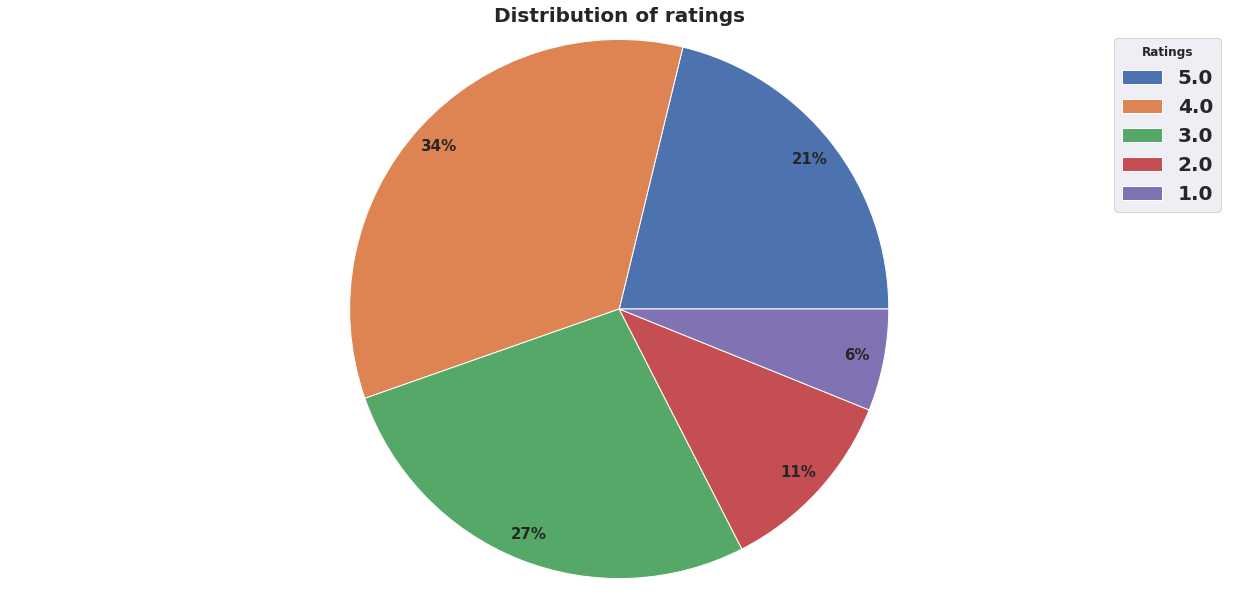

In [ ]:
data = ratings['rating'].value_counts().sort_index(ascending=False)
data.head()

plt.figure(figsize=(20,10))
plt.gca().axis("equal")
pie = plt.pie(data, startangle=0, autopct='%1.0f%%', pctdistance=0.9, radius=1.2,)
labels=data.index.unique()
plt.title('Distribution of ratings', weight='bold', size=20)
plt.legend(pie[0],labels, loc="best", fontsize=20, 
           bbox_transform=plt.gcf().transFigure,title='Ratings')
plt.subplots_adjust(left=0.0, bottom=0.1, right=0.85)

plt.show()
plt.clf()
plt.close()

In [ ]:
genre_count = movies[genre_cols].sum().to_dict()


![alt text](https://miro.medium.com/max/1000/1*ZKSTkWpJlGKIfYP9wDgz5w.jpeg)


In [ ]:
n_latent=5
n_movies=len(movies['movie_id'].values)
n_users=len(users['user_id'].values)

def split_dataframe(df, test_size):
  test = df.sample(frac=test_size, replace=False, random_state=1612)
  train = df[~df.index.isin(test.index)]
  return train, test

def scheduler(epoch):
  if epoch < 15:
    return 0.001
  else:
    return 0.001 * exp(0.1 * (10 - epoch))

In [ ]:
ratings.user_id = ratings.user_id.astype('category').cat.codes.values
ratings.movie_id = ratings.movie_id.astype('category').cat.codes.values

train_df, val_df = split_dataframe(ratings, test_size=0.4)
val_df, test_df = split_dataframe(val_df, test_size=0.5)
train_df.shape, val_df.shape, test_df.shape

((60000, 4), (20000, 4), (20000, 4))

In [ ]:
def create_mf_model():
  user_input = Input(shape=(1,), dtype='int64')
  user_embedding = Embedding(n_users, n_latent,name='user_embedding')(user_input)
  user_vec = Flatten()(user_embedding)

  movie_input = Input(shape=(1,), dtype='int64')
  movie_embedding = Embedding(n_movies, n_latent,name='movie_embedding')(movie_input)
  movie_vec = Flatten()(movie_embedding)
 
  dot = Dot(axes=(1), normalize=False)([user_vec, movie_vec])
  model = Model([user_input, movie_input], dot)
  return model

def create_deep_learning_model():
  user_input = Input(shape=(1,), dtype='int64')
  user_embedding = Embedding(n_users, n_latent,name='user_embedding')(user_input)
  user_vec = Flatten()(user_embedding)
  user_vec=Dropout(0.3)(user_vec)

  movie_input = Input(shape=(1,), dtype='int64')
  movie_embedding = Embedding(n_movies, n_latent,name='movie_embedding')(movie_input)
  movie_vec = Flatten()(movie_embedding)
  movie_vec=Dropout(0.3)(movie_vec)

  dot = Concatenate()([user_vec, movie_vec])

  dense=Dense(256,activation='relu')(dot)
  dense=Dropout(0.3)(dense)
  dense=Dense(128,activation='relu')(dense)
  dense=Dropout(0.3)(dense)
  out=Dense(1,activation='relu')(dense)

  model = Model([user_input, movie_input], out)
  return model

In [ ]:
mf_model = create_mf_model()
mf_model.summary()
mf_model.compile(loss='mse', optimizer=Adam())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 5)         4715        input_1[0][0]                    
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 5)         8410        input_2[0][0]                    
______________________________________________________________________________________________

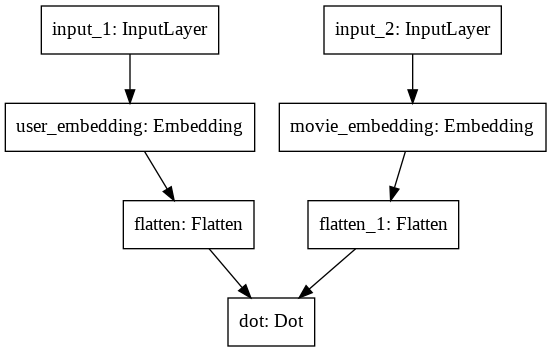

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(mf_model, os.path.join(PATH,'mf.png'))


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_decay = LearningRateScheduler(scheduler)

# mf_history = mf_model.fit([train_df.user_id, train_df.movie_id],
#           train_df.rating,
#           batch_size=128, 
#           epochs=200,
#           callbacks=[early_stop, lr_decay],
#           validation_data=([val_df.user_id, val_df.movie_id],val_df.rating))

mf_history = mf_model.fit([train_df.user_id, train_df.movie_id],
          train_df.rating,
          batch_size=128, 
          epochs=200,
          callbacks=[early_stop],
          validation_data=([val_df.user_id, val_df.movie_id],val_df.rating))

mf_model.save_weights(MF_WEIGHT_PATH)



Epoch 1/200
469/469 [==============================] - 1s 2ms/step - loss: 13.6905 - val_loss: 13.4865
Epoch 2/200
469/469 [==============================] - 1s 2ms/step - loss: 11.4255 - val_loss: 8.7273
Epoch 3/200
469/469 [==============================] - 1s 2ms/step - loss: 6.1407 - val_loss: 4.1799
Epoch 4/200
469/469 [==============================] - 1s 2ms/step - loss: 3.0580 - val_loss: 2.4074
Epoch 5/200
469/469 [==============================] - 1s 2ms/step - loss: 1.9704 - val_loss: 1.7674
Epoch 6/200
469/469 [==============================] - 1s 2ms/step - loss: 1.5218 - val_loss: 1.4534
Epoch 7/200
469/469 [==============================] - 1s 2ms/step - loss: 1.2837 - val_loss: 1.2735
Epoch 8/200
469/469 [==============================] - 1s 2ms/step - loss: 1.1428 - val_loss: 1.1628
Epoch 9/200
469/469 [==============================] - 1s 2ms/step - loss: 1.0538 - val_loss: 1.0911
Epoch 10/200
469/469 [==============================] - 1s 2ms/step - loss: 0.9949 - val

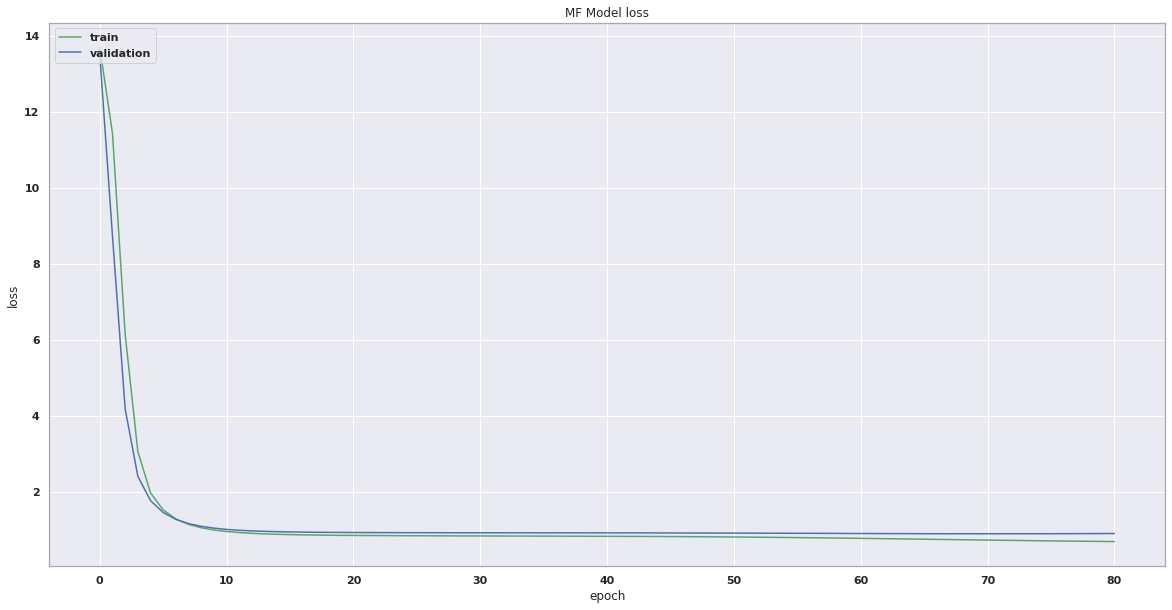

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(mf_history.history['loss'] , 'g')
plt.plot(mf_history.history['val_loss'] , 'b')
plt.title('MF Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
dl_model = create_deep_learning_model()
dl_model.summary()
dl_model.compile(loss='mse', optimizer=Adam())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 5)         4715        input_3[0][0]                    
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 5)         8410        input_4[0][0]                    
____________________________________________________________________________________________

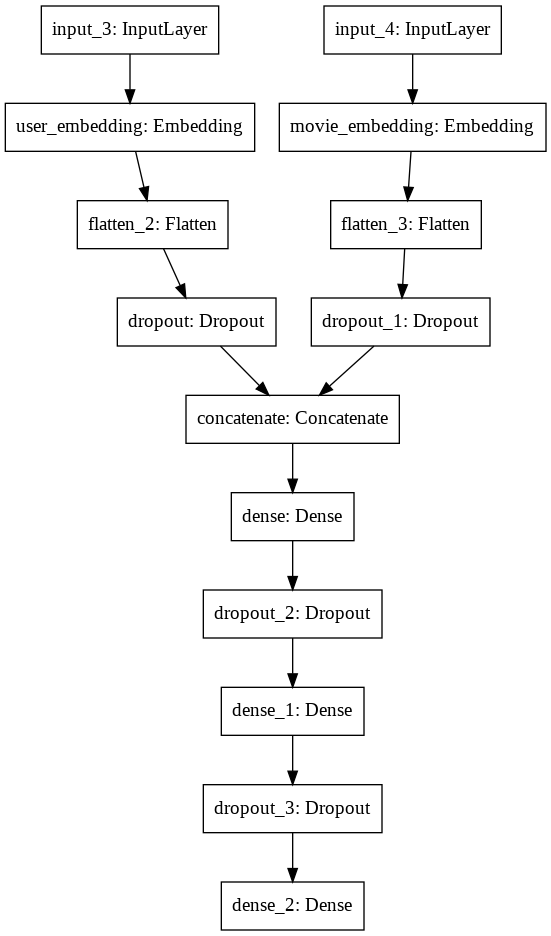

In [ ]:
plot_model(dl_model, os.path.join(PATH,'dl.png'))


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#lr_decay = LearningRateScheduler(scheduler)

# dl_history = dl_model.fit([train_df.user_id, train_df.movie_id],
#           train_df.rating,
#           batch_size=128, 
#           epochs=200,
#           callbacks=[early_stop, lr_decay],
#           validation_data=([val_df.user_id, val_df.movie_id],val_df.rating))

dl_history = dl_model.fit([train_df.user_id, train_df.movie_id],
          train_df.rating,
          batch_size=128, 
          epochs=200,
          callbacks=[early_stop, ],
          validation_data=([val_df.user_id, val_df.movie_id],val_df.rating))

dl_model.save_weights(DL_WEIGHT_PATH)

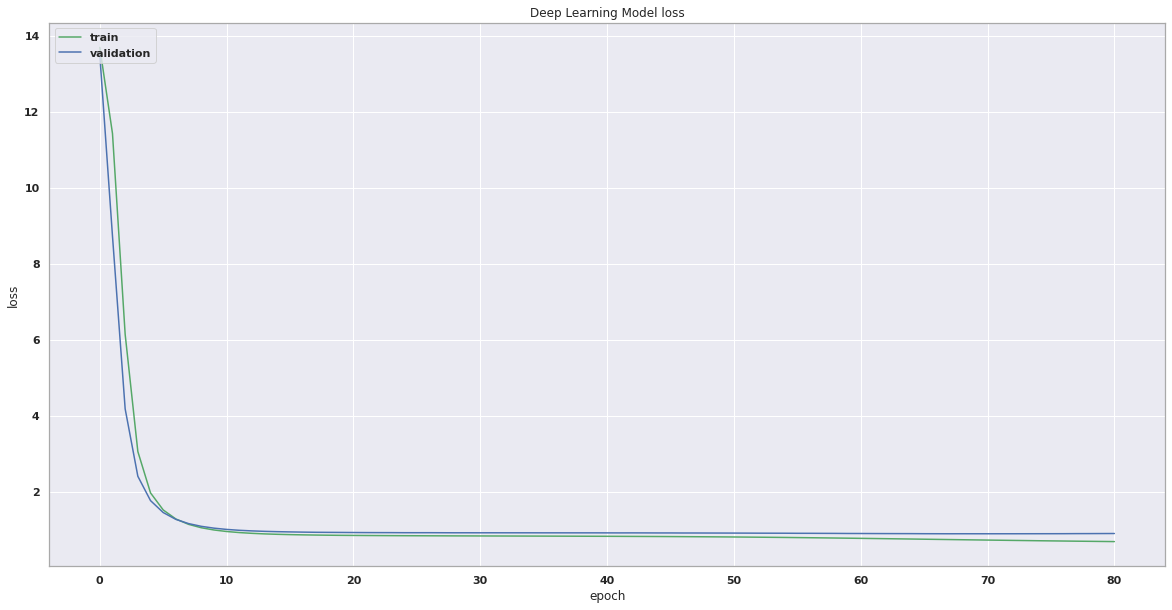

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(mf_history.history['loss'] , 'g')
plt.plot(mf_history.history['val_loss'] , 'b')
plt.title('Deep Learning Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
movies.movie_id = movies.movie_id.astype('category').cat.codes.values
users.user_id = users.user_id.astype('category').cat.codes.values

In [ ]:
ratings.loc[ratings['user_id'] == 195]

,user_id,movie_id,rating,unix_timestamp
291,195,1649,4.0,875155140
373,195,1234,3.0,876197678
411,195,1022,2.0,876197645
916,195,778,3.0,880314383
1010,195,1036,3.0,875154718
...,...,...,...,...
86426,195,765,4.0,875155257
87759,195,1037,3.0,880314383
91273,195,1325,3.0,880315080
92348,195,825,4.0,876198296


In [ ]:


movie_embedding_learnt = dl_model.get_layer(name='movie_embedding').get_weights()[0]
user_embedding_learnt = dl_model.get_layer(name='user_embedding').get_weights()[0]
print(movie_embedding_learnt)
print(user_embedding_learnt)
def recommend(user_id, number_of_movies=5):
  movies = user_embedding_learnt[user_id]@movie_embedding_learnt.T
  mids = np.argpartition(movies, -number_of_movies)[-number_of_movies:]
 
  return mids

recommend(195)
movies.loc[movies['movie_id'].isin(recommend(195))]


[[ 0.0758196  -0.09392608 -0.05711067 -0.09174915 -0.01588058]
 [-0.01719227  0.00247105  0.04815461 -0.0038364   0.01038618]
 [ 0.04317534 -0.09829813 -0.02603711 -0.05608213 -0.07190651]
 ...
 [-0.14035025  0.11543953  0.10030757  0.26190847 -0.00885259]
 [-0.17896706  0.17170598  0.15920272  0.23923114  0.17520317]
 [-0.05948078  0.07132335  0.00288995  0.0211954   0.0538659 ]]
[[-0.02834685  0.06811119 -0.10377378  0.06314013 -0.07714681]
 [-0.03333971 -0.00420002 -0.06300779  0.03726701 -0.01005285]
 [ 0.0110351  -0.04456013  0.02135333 -0.0043948  -0.02113947]
 ...
 [ 0.12072073 -0.04730705  0.0475143  -0.04911343 -0.05161768]
 [-0.02523102  0.02003845 -0.01110006 -0.10602333  0.06397223]
 [ 0.04316514 -0.03619931  0.04652941  0.08603495 -0.07203812]]


,movie_id,title,release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
1174,196,Hugo Pool (1997),01-Jan-1997,http://us.imdb.com/M/title-exact?Hugo+Pool+(1997),0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1997
1366,409,Faust (1994),01-Jan-1994,http://us.imdb.com/M/title-exact?Faust%20%2819...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1994
1466,520,"Saint of Fort Washington, The (1993)",01-Jan-1993,http://us.imdb.com/M/title-exact?Saint%20of%20...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1993
1499,556,Santa with Muscles (1996),08-Nov-1996,http://us.imdb.com/M/title-exact?Santa%20with%...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1996
1524,585,"Object of My Affection, The (1998)",20-Mar-1998,http://us.imdb.com/Title?Object+of+My+Affectio...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1998


In [ ]:
temp = dl_model.get_layer(name='movie_embedding').get_weights()

In [ ]:
#movies.loc[movies['movie_id'] == 123]
a = movies['movie_id'] == 123
movies[a]

,movie_id,title,release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
1108,123,Death and the Maiden (1994),01-Jan-1994,http://us.imdb.com/M/title-exact?Death%20and%2...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1994




---



---

